In [3]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from src import CompanyDetails
import datetime as dt

In [4]:
c_name = 'ITC'
details = CompanyDetails(c_name)

price_arr = details.sharePriceRange('4y', '1d')
for val in price_arr:
    print(val)

{'time': '2021-03-22', 'close': 194.12, 'volume': 46050245.0}
{'time': '2021-03-23', 'close': 190.85, 'volume': 41564683.0}
{'time': '2021-03-24', 'close': 185.48, 'volume': 27609243.0}
{'time': '2021-03-25', 'close': 181.75, 'volume': 40681282.0}
{'time': '2021-03-26', 'close': 181.15, 'volume': 26079435.0}
{'time': '2021-03-30', 'close': 184.28, 'volume': 27792033.0}
{'time': '2021-03-31', 'close': 187.67, 'volume': 36485322.0}
{'time': '2021-04-01', 'close': 189.01, 'volume': 29062762.0}
{'time': '2021-04-05', 'close': 182.56, 'volume': 31378045.0}
{'time': '2021-04-06', 'close': 182.65, 'volume': 25674227.0}
{'time': '2021-04-07', 'close': 183.64, 'volume': 15204883.0}
{'time': '2021-04-08', 'close': 183.17, 'volume': 14116874.0}
{'time': '2021-04-09', 'close': 183.04, 'volume': 16364247.0}
{'time': '2021-04-12', 'close': 176.34, 'volume': 34511670.0}
{'time': '2021-04-13', 'close': 179.26, 'volume': 20247639.0}
{'time': '2021-04-15', 'close': 177.54, 'volume': 17530742.0}
{'time':

In [5]:
df = pd.DataFrame(price_arr)
df.reset_index()
# print(df.shape)
# print(df.info)
# print(df.describe())
print(df.head())

         time   close      volume
0  2021-03-22  194.12  46050245.0
1  2021-03-23  190.85  41564683.0
2  2021-03-24  185.48  27609243.0
3  2021-03-25  181.75  40681282.0
4  2021-03-26  181.15  26079435.0


In [6]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, date = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year, month=month, day=date)

df['time'] = df['time'].apply(str_to_datetime)
df.index = df.pop('time')
print(df)

             close      volume
time                          
2021-03-22  194.12  46050245.0
2021-03-23  190.85  41564683.0
2021-03-24  185.48  27609243.0
2021-03-25  181.75  40681282.0
2021-03-26  181.15  26079435.0
...            ...         ...
2025-03-13  412.05   8196569.0
2025-03-17  407.95   5257805.0
2025-03-18  407.95         0.0
2025-03-19  403.05  12830387.0
2025-03-20  403.95  16982545.0

[989 rows x 2 columns]


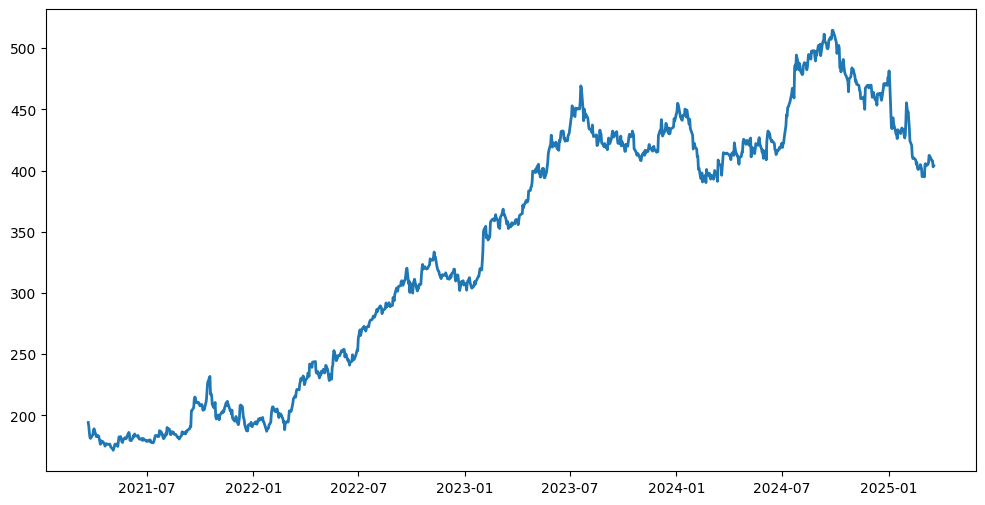

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], linewidth = 2)

In [8]:
ma100 = df.close.rolling(100).mean()
ma200 = df.close.rolling(200).mean()
df['ma100'] = ma100
df['ma200'] = ma200
print(df)

             close      volume     ma100      ma200
time                                               
2021-03-22  194.12  46050245.0       NaN        NaN
2021-03-23  190.85  41564683.0       NaN        NaN
2021-03-24  185.48  27609243.0       NaN        NaN
2021-03-25  181.75  40681282.0       NaN        NaN
2021-03-26  181.15  26079435.0       NaN        NaN
...            ...         ...       ...        ...
2025-03-13  412.05   8196569.0  445.1262  457.75900
2025-03-17  407.95   5257805.0  444.4626  457.71445
2025-03-18  407.95         0.0  443.8132  457.70425
2025-03-19  403.05  12830387.0  443.2000  457.65695
2025-03-20  403.95  16982545.0  442.4914  457.59530

[989 rows x 4 columns]


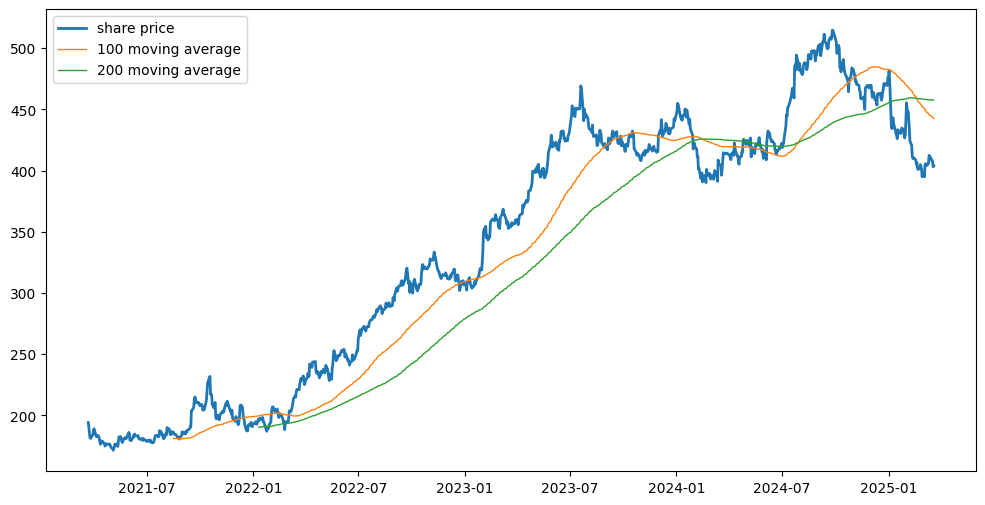

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.close, label = 'share price', linewidth=2)
plt.plot(df.ma100, label='100 moving average', linewidth=1)
plt.plot(df.ma200, label='200 moving average', linewidth=1)
plt.legend()
plt.show()

In [10]:
ema100 = df.close.ewm(span=100, adjust=False).mean()
ema200 = df.close.ewm(span=200, adjust=False).mean()
df['ema100'] = ema100
df['ema200'] = ema200
print(df.tail())

             close      volume     ma100      ma200      ema100      ema200
time                                                                       
2025-03-13  412.05   8196569.0  445.1262  457.75900  437.457900  443.943360
2025-03-17  407.95   5257805.0  444.4626  457.71445  436.873585  443.585217
2025-03-18  407.95         0.0  443.8132  457.70425  436.300841  443.230638
2025-03-19  403.05  12830387.0  443.2000  457.65695  435.642408  442.830830
2025-03-20  403.95  16982545.0  442.4914  457.59530  435.014836  442.443956


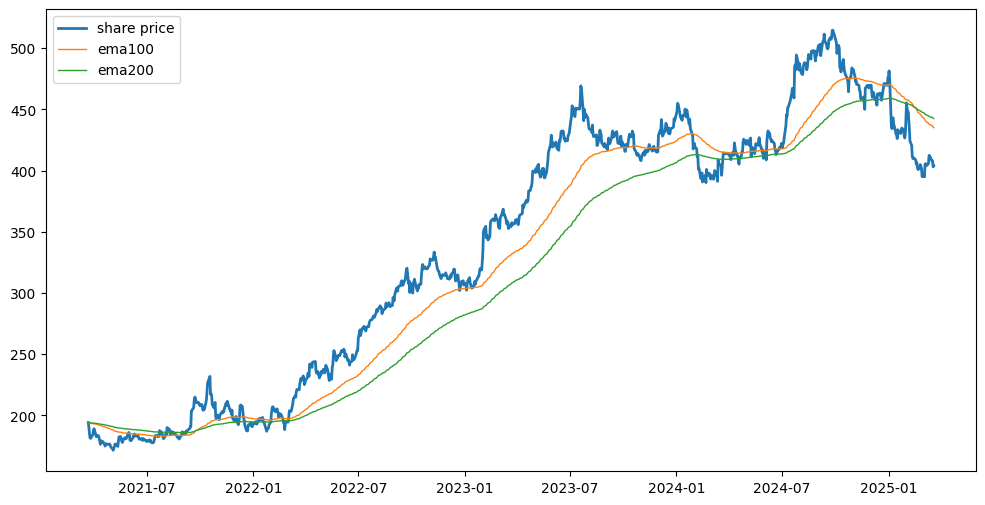

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.close, label='share price', linewidth=2)
plt.plot(df.ema100, label='ema100', linewidth=1)
plt.plot(df.ema200, label='ema200', linewidth=1)
plt.legend()

In [14]:
# Training & Testing

data_training = pd.DataFrame(df['close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['close'][int(len(df)*0.70): int(len(df))])

In [17]:
print(data_training)
print(data_testing)

             close
time              
2021-03-22  194.12
2021-03-23  190.85
2021-03-24  185.48
2021-03-25  181.75
2021-03-26  181.15
...            ...
2024-01-01  446.19
2024-01-02  448.39
2024-01-03  454.96
2024-01-04  454.15
2024-01-05  451.82

[692 rows x 1 columns]
             close
time              
2024-01-08  443.76
2024-01-09  442.86
2024-01-10  441.67
2024-01-11  441.05
2024-01-12  444.91
...            ...
2025-03-13  412.05
2025-03-17  407.95
2025-03-18  407.95
2025-03-19  403.05
2025-03-20  403.95

[297 rows x 1 columns]


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

In [23]:
data_training_array = scaler.fit_transform(data_training)
print(data_training_array)
print(data_training_array.shape)

[[0.0761764 ]
 [0.0651933 ]
 [0.04715682]
 [0.03462869]
 [0.03261344]
 [0.04312632]
 [0.05451248]
 [0.0590132 ]
 [0.03734928]
 [0.03765156]
 [0.04097672]
 [0.03939811]
 [0.03896148]
 [0.01645786]
 [0.02626541]
 [0.02048836]
 [0.02408222]
 [0.01729755]
 [0.01138616]
 [0.01817083]
 [0.01659221]
 [0.01645786]
 [0.01672656]
 [0.01702885]
 [0.01356934]
 [0.00866557]
 [0.00389615]
 [0.        ]
 [0.00520606]
 [0.00910221]
 [0.01659221]
 [0.0171632 ]
 [0.01269607]
 [0.01054647]
 [0.03650959]
 [0.03751721]
 [0.03016156]
 [0.02351124]
 [0.02136164]
 [0.02727303]
 [0.0343264 ]
 [0.03261344]
 [0.03174017]
 [0.03331878]
 [0.0383569 ]
 [0.04903772]
 [0.04514157]
 [0.0271051 ]
 [0.02727303]
 [0.02639976]
 [0.03419205]
 [0.04054009]
 [0.03721493]
 [0.04477211]
 [0.04064085]
 [0.03886071]
 [0.03812179]
 [0.04047291]
 [0.03395694]
 [0.03069896]
 [0.03039667]
 [0.03231115]
 [0.02891882]
 [0.0268364 ]
 [0.0321768 ]
 [0.02787761]
 [0.02700433]
 [0.0252242 ]
 [0.02609747]
 [0.02431733]
 [0.02801196]
 [0.02

In [33]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train  = np.array(x_train), np.array(y_train)
print(x_train)

[[[0.0761764 ]
  [0.0651933 ]
  [0.04715682]
  ...
  [0.04359655]
  [0.05115373]
  [0.04950794]]

 [[0.0651933 ]
  [0.04715682]
  [0.03462869]
  ...
  [0.05115373]
  [0.04950794]
  [0.04446982]]

 [[0.04715682]
  [0.03462869]
  [0.03261344]
  ...
  [0.04950794]
  [0.04446982]
  [0.0437309 ]]

 ...

 [[0.88073086]
  [0.87256911]
  [0.89272159]
  ...
  [0.90377187]
  [0.92281597]
  [0.93020522]]

 [[0.87256911]
  [0.89272159]
  [0.87062103]
  ...
  [0.92281597]
  [0.93020522]
  [0.95227219]]

 [[0.89272159]
  [0.87062103]
  [0.86101501]
  ...
  [0.93020522]
  [0.95227219]
  [0.94955161]]]


In [34]:
print(y_train)

[0.04446982 0.0437309  0.04359655 0.03587143 0.03425923 0.03617371
 0.03083331 0.03469587 0.04090955 0.05071709 0.04537668 0.04611561
 0.04863467 0.04477211 0.05206059 0.05054916 0.054714   0.05914755
 0.06495818 0.0646559  0.10838679 0.10956236 0.11728748 0.14026131
 0.14617271 0.14321701 0.13122628 0.1319652  0.12914386 0.13018507
 0.12440802 0.12202331 0.12571793 0.12010882 0.10986464 0.11490276
 0.11120814 0.13001713 0.13965674 0.1631008  0.18489907 0.20266685
 0.15346119 0.15537568 0.14973298 0.12571793 0.11624626 0.12602022
 0.13122628 0.09162664 0.08598395 0.0968327  0.09310449 0.08376717
 0.09592584 0.10556545 0.10244181 0.10868908 0.10617002 0.11476841
 0.13018507 0.1223256  0.13431633 0.12840493 0.10882343 0.11090585
 0.09935176 0.10999899 0.08836866 0.08094582 0.07990461 0.08215497
 0.09266785 0.08138246 0.07026501 0.07842676 0.09119    0.12215766
 0.12424008 0.11980654 0.10200517 0.08850301 0.08511067 0.07043294
 0.05397508 0.05427737 0.05279952 0.06848487 0.07056729 0.0692

In [37]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [38]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
19/19 [==============================] - 12s 265ms/step - loss: 0.1155
Epoch 2/50
19/19 [==============================] - 5s 259ms/step - loss: 0.0198
Epoch 3/50
19/19 [==============================] - 5s 266ms/step - loss: 0.0132
Epoch 4/50
19/19 [==============================] - 5s 267ms/step - loss: 0.0107
Epoch 5/50
19/19 [==============================] - 5s 287ms/step - loss: 0.0112
Epoch 6/50
19/19 [==============================] - 6s 300ms/step - loss: 0.0116
Epoch 7/50
19/19 [==============================] - 6s 303ms/step - loss: 0.0104
Epoch 8/50
19/19 [==============================] - 5s 282ms/step - loss: 0.0086
Epoch 9/50
19/19 [==============================] - 5s 285ms/step - loss: 0.0091
Epoch 10/50
19/19 [==============================] - 5s 263ms/step - loss: 0.0088
Epoch 11/50
19/19 [==============================] - 5s 264ms/step - loss: 0.0090
Epoch 12/50
19/19 [==============================] - 5s 263ms/step - loss: 0.0091
Epoch 13/50
19/19 [=====

In [40]:
past_100_days = data_training.tail(100)
print(past_100_days)

             close
time              
2023-08-10  430.65
2023-08-11  427.79
2023-08-14  428.22
2023-08-16  429.22
2023-08-17  420.41
...            ...
2024-01-01  446.19
2024-01-02  448.39
2024-01-03  454.96
2024-01-04  454.15
2024-01-05  451.82

[100 rows x 1 columns]


TypeError: add() got an unexpected keyword argument 'ignore_index'